In [14]:
import numpy as np
import pandas as pd
import pickle
import random
import tensorflow as tf
import os
import sys
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.stats import gaussian_kde, norm
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture

from vae.vae import SVAE
from vae.train import train,train_new
from utils.data_processing import prep_data, make_tf_batches, seq_to_onehot
from vae.predict import predict
from utils.utils_f4f import heatmap, si_format
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '0'


In [15]:
def normdata(data):
    max_val = max(data)
    min_val = min(data)

    norm_data = 10*(data - min_val)/(max_val - min_val) -5

    return norm_data

#### Data_preparetion

In [16]:
df_all = pd.read_csv('../data/2nd_Top50_exprement.tsv',delimiter='\t')
df_all = df_all.rename(columns={'aa':'AA_sequence'})


#### AA-sequence-nor_package

In [17]:
aa_nor_package = df_all[['AA_sequence', 'nor_package']]
aa_nor_package = aa_nor_package.sort_values(by='nor_package')
(data_list, train_df, test_df, prepped_df) = prep_data(aa_nor_package,AA_colname = 'AA_sequence', target_assay_col="nor_package")
prepped_df['Y--nor_package'] = aa_nor_package['AA_sequence'].map(aa_nor_package.drop_duplicates('AA_sequence').set_index('AA_sequence')['nor_package'])
top50_df =  prepped_df.drop(columns=['test','AA_sequence','Y--nor_package'])
AA_sequence = prepped_df['AA_sequence'] 
array = 'AA_sequence'

##### First model(1st_aa_nor_package) 

2/2 [==============================] - 0s 0s/step


d:\ProgramData\anaconda3\envs\tf\lib\site-packages\numpy\lib\histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


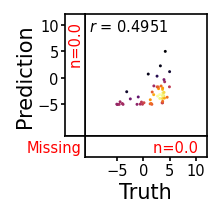

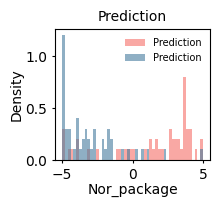

In [18]:
model_outdir = 'pretrain\model_1st_aa_nor_package'
model_outpath = model_outdir
model = tf.keras.models.load_model(model_outdir)
preds_top50 = predict(model, top50_df ,array,Y=None,AA=AA_sequence)
preds_top50['y_true'] = preds_top50['AA_sequence'].map(aa_nor_package.drop_duplicates('AA_sequence').set_index('AA_sequence')['nor_package'])
preds_top50['y_pred'].corr(preds_top50['y_true'])

preds_top50['norm_pred'] = normdata(preds_top50['y_pred'])
preds_top50['norm_true'] = normdata(preds_top50['y_true'])

x = preds_top50['norm_pred']
y = preds_top50['norm_true']

remove = np.isinf(x) & np.isinf(y)
x = x[~remove]
y = y[~remove]

keep = (~np.isinf(x)) & (~np.isinf(y))
x_both = x[keep]
y_both = y[keep]

y_missing = y[np.isinf(x)]
x_missing = x[np.isinf(y)]


kernel = gaussian_kde(np.vstack([
    x_both.sample(n=50, random_state=1), 
    y_both.sample(n=50, random_state=1)
]))
c_both = kernel(np.vstack([x_both.values, y_both.values]))

fig = plt.figure(figsize=(1.4,1.3), dpi=150)

gs = fig.add_gridspec(2, 2, left=0.275, right=0.95, bottom=0.22, top=0.95, 
                      width_ratios=[1, 6], height_ratios=[6, 1], hspace=0., wspace=0)
ax = fig.add_subplot(gs[0, 1])
ax.scatter(x_both, y_both, c=c_both, cmap=mpl.cm.inferno, s=2, edgecolor='none', rasterized=True)
ax.set_xticks([]); ax.set_yticks([])
xlim = [-11, 12]
bins = np.linspace(*xlim, 25)
ax.set_xlim(xlim); ax.set_ylim(xlim)
ax.text(0.03, 0.97, r'$r$ = {:.4f}'.format(np.corrcoef(x_both, y_both)[0, 1]),
       transform=ax.transAxes, ha='left', va='top', fontsize=7)

# ax.text(0.97, 0.01, 'n={}'.format(si_format(len(x_both)), precision=2, format_str='{value}{prefix}',), 
        # transform=ax.transAxes, ha='right', va='bottom', fontsize=7)

# Left Marginal
ax = fig.add_subplot(gs[0, 0])
ax.hist(y_missing, bins=bins, edgecolor='none', orientation='horizontal', density=True, color='r')
ax.set_ylim(xlim)
ax.set_xticks([]); ax.set_yticks([-5, 0, 5, 10])
ax.text(0.97, 0.97, 'n={}'.format(si_format(len(y_missing)), precision=2, format_str='{value}{prefix}',), 
        transform=ax.transAxes, ha='right', va='top', fontsize=7, rotation=90, color='r')
ax.set_ylabel('Prediction', labelpad=1)
ax.tick_params(axis='both', labelsize=7, length=2, pad=1)

# Bottom Marginal
ax = fig.add_subplot(gs[1, 1])
ax.hist(x_missing, bins=bins, edgecolor='none', density=True, color='r')
ax.set_xlim(xlim)
ax.set_xticks([-5, 0, 5, 10]); ax.set_yticks([])
ax.text(0.97, 0.8, 'n={}'.format(si_format(len(x_missing)), precision=4, format_str='{value}{prefix}',), 
        transform=ax.transAxes, ha='right', va='top', fontsize=7, color='r')
ax.set_xlabel('Truth', labelpad=2)
ax.tick_params(axis='both', labelsize=7, length=2, pad=1)

# Missing label (not detected in either)
ax = fig.add_subplot(gs[1, 0])
for spine in ['bottom', 'left']:
    ax.spines[spine].set_visible(False)
ax.set_xticks([]); ax.set_yticks([])

ax.text(0.8, 0.8, 'Missing', transform=ax.transAxes, color='r', ha='right', va='top', fontsize=7, clip_on=False)
# fig.savefig('../results/vae/2nd_results/2nd_vae_Top50_aa_nor_package_correlation.pdf',dpi=300,bbox_inches='tight')
plt.show()






data1 = np.array(preds_top50['norm_pred']) 
data1 = data1.reshape(-1, 1)  # 将数据转换成列向量的形式
data2 = np.array(preds_top50['norm_true']) 
data2 = data2.reshape(-1, 1)  # 将数据转换成列向量的形式
fig,ax = plt.subplots(figsize=(2,1.7),dpi=100)
# 绘制原始数据和拟合后的分布
plt.hist(data1, bins=50, density=True, alpha=0.6, color = '#F66E68',label='Prediction')
plt.hist(data2, bins=50, density=True, alpha=0.6, color = '#457B9D',label='Truth')
plt.title('Prediction',fontsize=10)
ax.tick_params(axis='both', which='both', length=2,labelsize=10)
ax.set_xticks([-5, 0, 5]); 
# ax.set_yticks([])
plt.ylabel('Density',labelpad=1,fontsize=10)
plt.xlabel('Nor_package',labelpad=1,fontsize=10)
plt.legend(fontsize=7,frameon=False)
# fig.savefig('../results/vae/2nd_results/2nd_vae_Top50_aa_nor_package_distribution.pdf',dpi=300,bbox_inches='tight')


##### Second model(2nd_aa_nor_package) 

2/2 [==============================] - 0s 3ms/step


d:\ProgramData\anaconda3\envs\tf\lib\site-packages\numpy\lib\histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


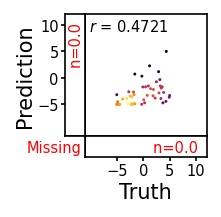

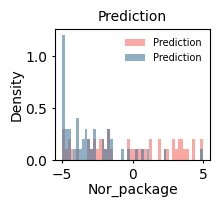

In [19]:
model_outdir = 'pretrain\\model_2nd_aa_nor_package'
model_outpath = model_outdir
model = tf.keras.models.load_model(model_outdir)
preds_top50 = predict(model, top50_df ,array,Y=None,AA=AA_sequence)
preds_top50['y_true'] = preds_top50['AA_sequence'].map(aa_nor_package.drop_duplicates('AA_sequence').set_index('AA_sequence')['nor_package'])
preds_top50['y_pred'].corr(preds_top50['y_true'])

preds_top50['norm_pred'] = normdata(preds_top50['y_pred'])
preds_top50['norm_true'] = normdata(preds_top50['y_true'])

x = preds_top50['norm_pred']
y = preds_top50['norm_true']

remove = np.isinf(x) & np.isinf(y)
x = x[~remove]
y = y[~remove]

keep = (~np.isinf(x)) & (~np.isinf(y))
x_both = x[keep]
y_both = y[keep]

y_missing = y[np.isinf(x)]
x_missing = x[np.isinf(y)]


kernel = gaussian_kde(np.vstack([
    x_both.sample(n=50, random_state=1), 
    y_both.sample(n=50, random_state=1)
]))
c_both = kernel(np.vstack([x_both.values, y_both.values]))

fig = plt.figure(figsize=(1.4,1.3), dpi=150)

gs = fig.add_gridspec(2, 2, left=0.275, right=0.95, bottom=0.22, top=0.95, 
                      width_ratios=[1, 6], height_ratios=[6, 1], hspace=0., wspace=0)
ax = fig.add_subplot(gs[0, 1])
ax.scatter(x_both, y_both, c=c_both, cmap=mpl.cm.inferno, s=2, edgecolor='none', rasterized=True)
ax.set_xticks([]); ax.set_yticks([])
xlim = [-11, 12]
bins = np.linspace(*xlim, 25)
ax.set_xlim(xlim); ax.set_ylim(xlim)
ax.text(0.03, 0.97, r'$r$ = {:.4f}'.format(np.corrcoef(x_both, y_both)[0, 1]),
       transform=ax.transAxes, ha='left', va='top', fontsize=7)


# Left Marginal
ax = fig.add_subplot(gs[0, 0])
ax.hist(y_missing, bins=bins, edgecolor='none', orientation='horizontal', density=True, color='r')
ax.set_ylim(xlim)
ax.set_xticks([]); ax.set_yticks([-5, 0, 5, 10])
ax.text(0.97, 0.97, 'n={}'.format(si_format(len(y_missing)), precision=2, format_str='{value}{prefix}',), 
        transform=ax.transAxes, ha='right', va='top', fontsize=7, rotation=90, color='r')
ax.set_ylabel('Prediction', labelpad=1)
ax.tick_params(axis='both', labelsize=7, length=2, pad=1)

# Bottom Marginal
ax = fig.add_subplot(gs[1, 1])
ax.hist(x_missing, bins=bins, edgecolor='none', density=True, color='r')
ax.set_xlim(xlim)
ax.set_xticks([-5, 0, 5, 10]); ax.set_yticks([])
ax.text(0.97, 0.8, 'n={}'.format(si_format(len(x_missing)), precision=4, format_str='{value}{prefix}',), 
        transform=ax.transAxes, ha='right', va='top', fontsize=7, color='r')
ax.set_xlabel('Truth', labelpad=2)
ax.tick_params(axis='both', labelsize=7, length=2, pad=1)

# Missing label (not detected in either)
ax = fig.add_subplot(gs[1, 0])
for spine in ['bottom', 'left']:
    ax.spines[spine].set_visible(False)
ax.set_xticks([]); ax.set_yticks([])

ax.text(0.8, 0.8, 'Missing', transform=ax.transAxes, color='r', ha='right', va='top', fontsize=7, clip_on=False)
# fig.savefig('../results/vae/2nd_results/2nd_vae_Top50_aa_nor_package_correlation.pdf',dpi=300,bbox_inches='tight')
plt.show()






data1 = np.array(preds_top50['norm_pred']) 
data1 = data1.reshape(-1, 1)  # 将数据转换成列向量的形式
data2 = np.array(preds_top50['norm_true']) 
data2 = data2.reshape(-1, 1)  # 将数据转换成列向量的形式
fig,ax = plt.subplots(figsize=(2,1.7),dpi=100)
# 绘制原始数据和拟合后的分布
plt.hist(data1, bins=50, density=True, alpha=0.6, color = '#F66E68',label='Prediction')
plt.hist(data2, bins=50, density=True, alpha=0.6, color = '#457B9D',label='Truth')
plt.title('Prediction',fontsize=10)
ax.tick_params(axis='both', which='both', length=2,labelsize=10)
ax.set_xticks([-5, 0, 5]); 
# ax.set_yticks([])
plt.ylabel('Density',labelpad=1,fontsize=10)
plt.xlabel('Nor_package',labelpad=1,fontsize=10)
plt.legend(fontsize=7,frameon=False)
# fig.savefig('../results/vae/2nd_results/2nd_vae_Top50_aa_nor_package_distribution.pdf',dpi=300,bbox_inches='tight')


#### seq-nor_package

In [20]:
seq_nor_package = df_all[['seq', 'nor_package']]
seq_nor_package = seq_nor_package.sort_values(by='nor_package')
(data_list, train_df, test_df, prepped_df) = prep_data(seq_nor_package,AA_colname = 'seq', target_assay_col="nor_package")
prepped_df['Y--nor_package'] = seq_nor_package['seq'].map(seq_nor_package.drop_duplicates('seq').set_index('seq')['nor_package'])
top50_df =  prepped_df.drop(columns=['test','seq','Y--nor_package'])
AA_sequence = prepped_df['seq'] 
array = 'seq'

##### First model(1st_seq_nor_package) 

2/2 [==============================] - 0s 2ms/step


d:\ProgramData\anaconda3\envs\tf\lib\site-packages\numpy\lib\histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


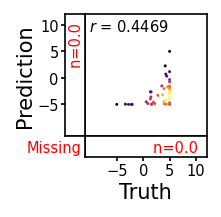

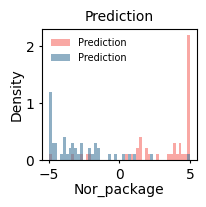

In [21]:
model_outdir = 'pretrain\model_1st_seq_nor_package'
model_outpath = model_outdir
model = tf.keras.models.load_model(model_outdir)
preds_top50 = predict(model, top50_df ,array,Y=None,AA=AA_sequence)

preds_top50['y_true'] = preds_top50['seq'].map(seq_nor_package.drop_duplicates('seq').set_index('seq')['nor_package'])
preds_top50['y_pred'].corr(preds_top50['y_true'])

preds_top50['norm_pred'] = normdata(preds_top50['y_pred'])
preds_top50['norm_true'] = normdata(preds_top50['y_true'])

x = preds_top50['norm_pred']
y = preds_top50['norm_true']

remove = np.isinf(x) & np.isinf(y)
x = x[~remove]
y = y[~remove]

keep = (~np.isinf(x)) & (~np.isinf(y))
x_both = x[keep]
y_both = y[keep]

y_missing = y[np.isinf(x)]
x_missing = x[np.isinf(y)]


kernel = gaussian_kde(np.vstack([
    x_both.sample(n=50, random_state=1), 
    y_both.sample(n=50, random_state=1)
]))
c_both = kernel(np.vstack([x_both.values, y_both.values]))

fig = plt.figure(figsize=(1.4,1.3), dpi=150)
gs = fig.add_gridspec(2, 2, left=0.275, right=0.95, bottom=0.22, top=0.95, 
                      width_ratios=[1, 6], height_ratios=[6, 1], hspace=0., wspace=0)
ax = fig.add_subplot(gs[0, 1])
ax.scatter(x_both, y_both, c=c_both, cmap=mpl.cm.inferno, s=2, edgecolor='none', rasterized=True)
ax.set_xticks([]); ax.set_yticks([])
xlim = [-11, 12]
bins = np.linspace(*xlim, 25)
ax.set_xlim(xlim); ax.set_ylim(xlim)
ax.text(0.03, 0.97, r'$r$ = {:.4f}'.format(np.corrcoef(x_both, y_both)[0, 1]),
       transform=ax.transAxes, ha='left', va='top', fontsize=7)

# ax.text(0.97, 0.01, 'n={}'.format(si_format(len(x_both)), precision=2, format_str='{value}{prefix}',), 
        # transform=ax.transAxes, ha='right', va='bottom', fontsize=7)

# Left Marginal
ax = fig.add_subplot(gs[0, 0])
ax.hist(y_missing, bins=bins, edgecolor='none', orientation='horizontal', density=True, color='r')
ax.set_ylim(xlim)
ax.set_xticks([]); ax.set_yticks([-5, 0, 5, 10])
ax.text(0.97, 0.97, 'n={}'.format(si_format(len(y_missing)), precision=2, format_str='{value}{prefix}',), 
        transform=ax.transAxes, ha='right', va='top', fontsize=7, rotation=90, color='r')
ax.set_ylabel('Prediction', labelpad=1)
ax.tick_params(axis='both', labelsize=7, length=2, pad=1)

# Bottom Marginal
ax = fig.add_subplot(gs[1, 1])
ax.hist(x_missing, bins=bins, edgecolor='none', density=True, color='r')
ax.set_xlim(xlim)
ax.set_xticks([-5, 0, 5, 10]); ax.set_yticks([])
ax.text(0.97, 0.8, 'n={}'.format(si_format(len(x_missing)), precision=4, format_str='{value}{prefix}',), 
        transform=ax.transAxes, ha='right', va='top', fontsize=7, color='r')
ax.set_xlabel('Truth', labelpad=2)
ax.tick_params(axis='both', labelsize=7, length=2, pad=1)

# Missing label (not detected in either)
ax = fig.add_subplot(gs[1, 0])
for spine in ['bottom', 'left']:
    ax.spines[spine].set_visible(False)
ax.set_xticks([]); ax.set_yticks([])

ax.text(0.8, 0.8, 'Missing', transform=ax.transAxes, color='r', ha='right', va='top', fontsize=7, clip_on=False)
# fig.savefig('../results/vae/2nd_results/2nd_vae_Top50_aa_nor_package_correlation.pdf',dpi=300,bbox_inches='tight')
plt.show()






data1 = np.array(preds_top50['norm_pred']) 
data1 = data1.reshape(-1, 1)  # 将数据转换成列向量的形式
data2 = np.array(preds_top50['norm_true']) 
data2 = data2.reshape(-1, 1)  # 将数据转换成列向量的形式
fig,ax = plt.subplots(figsize=(2,1.7),dpi=100)
# 绘制原始数据和拟合后的分布
plt.hist(data1, bins=50, density=True, alpha=0.6, color = '#F66E68',label='Prediction')
plt.hist(data2, bins=50, density=True, alpha=0.6, color = '#457B9D',label='Truth')
plt.title('Prediction',fontsize=10)
ax.tick_params(axis='both', which='both', length=2,labelsize=10)
ax.set_xticks([-5, 0, 5]); 
# ax.set_yticks([])
plt.ylabel('Density',labelpad=1,fontsize=10)
plt.xlabel('Nor_package',labelpad=1,fontsize=10)
plt.legend(fontsize=7,frameon=False)
# fig.savefig('../results/vae/2nd_results/2nd_vae_Top50_aa_nor_package_distribution.pdf',dpi=300,bbox_inches='tight')


##### Second model(2nd_aa_nor_package) 

2/2 [==============================] - 0s 4ms/step


d:\ProgramData\anaconda3\envs\tf\lib\site-packages\numpy\lib\histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


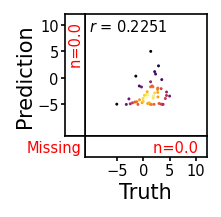

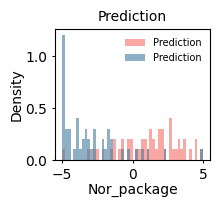

In [22]:
model_outdir = 'pretrain\model_2nd_seq_nor_package'
model_outpath = model_outdir
model = tf.keras.models.load_model(model_outdir)
preds_top50 = predict(model, top50_df ,array,Y=None,AA=AA_sequence)

preds_top50['y_true'] = preds_top50['seq'].map(seq_nor_package.drop_duplicates('seq').set_index('seq')['nor_package'])
preds_top50['y_pred'].corr(preds_top50['y_true'])

preds_top50['norm_pred'] = normdata(preds_top50['y_pred'])
preds_top50['norm_true'] = normdata(preds_top50['y_true'])

x = preds_top50['norm_pred']
y = preds_top50['norm_true']

remove = np.isinf(x) & np.isinf(y)
x = x[~remove]
y = y[~remove]

keep = (~np.isinf(x)) & (~np.isinf(y))
x_both = x[keep]
y_both = y[keep]

y_missing = y[np.isinf(x)]
x_missing = x[np.isinf(y)]


kernel = gaussian_kde(np.vstack([
    x_both.sample(n=50, random_state=1), 
    y_both.sample(n=50, random_state=1)
]))
c_both = kernel(np.vstack([x_both.values, y_both.values]))

fig = plt.figure(figsize=(1.4,1.3), dpi=150)
gs = fig.add_gridspec(2, 2, left=0.275, right=0.95, bottom=0.22, top=0.95, 
                      width_ratios=[1, 6], height_ratios=[6, 1], hspace=0., wspace=0)
ax = fig.add_subplot(gs[0, 1])
ax.scatter(x_both, y_both, c=c_both, cmap=mpl.cm.inferno, s=2, edgecolor='none', rasterized=True)
ax.set_xticks([]); ax.set_yticks([])
xlim = [-11, 12]
bins = np.linspace(*xlim, 25)
ax.set_xlim(xlim); ax.set_ylim(xlim)
ax.text(0.03, 0.97, r'$r$ = {:.4f}'.format(np.corrcoef(x_both, y_both)[0, 1]),
       transform=ax.transAxes, ha='left', va='top', fontsize=7)

# ax.text(0.97, 0.01, 'n={}'.format(si_format(len(x_both)), precision=2, format_str='{value}{prefix}',), 
        # transform=ax.transAxes, ha='right', va='bottom', fontsize=7)

# Left Marginal
ax = fig.add_subplot(gs[0, 0])
ax.hist(y_missing, bins=bins, edgecolor='none', orientation='horizontal', density=True, color='r')
ax.set_ylim(xlim)
ax.set_xticks([]); ax.set_yticks([-5, 0, 5, 10])
ax.text(0.97, 0.97, 'n={}'.format(si_format(len(y_missing)), precision=2, format_str='{value}{prefix}',), 
        transform=ax.transAxes, ha='right', va='top', fontsize=7, rotation=90, color='r')
ax.set_ylabel('Prediction', labelpad=1)
ax.tick_params(axis='both', labelsize=7, length=2, pad=1)

# Bottom Marginal
ax = fig.add_subplot(gs[1, 1])
ax.hist(x_missing, bins=bins, edgecolor='none', density=True, color='r')
ax.set_xlim(xlim)
ax.set_xticks([-5, 0, 5, 10]); ax.set_yticks([])
ax.text(0.97, 0.8, 'n={}'.format(si_format(len(x_missing)), precision=4, format_str='{value}{prefix}',), 
        transform=ax.transAxes, ha='right', va='top', fontsize=7, color='r')
ax.set_xlabel('Truth', labelpad=2)
ax.tick_params(axis='both', labelsize=7, length=2, pad=1)

# Missing label (not detected in either)
ax = fig.add_subplot(gs[1, 0])
for spine in ['bottom', 'left']:
    ax.spines[spine].set_visible(False)
ax.set_xticks([]); ax.set_yticks([])

ax.text(0.8, 0.8, 'Missing', transform=ax.transAxes, color='r', ha='right', va='top', fontsize=7, clip_on=False)
# fig.savefig('../results/vae/2nd_results/2nd_vae_Top50_aa_nor_package_correlation.pdf',dpi=300,bbox_inches='tight')
plt.show()






data1 = np.array(preds_top50['norm_pred']) 
data1 = data1.reshape(-1, 1)  # 将数据转换成列向量的形式
data2 = np.array(preds_top50['norm_true']) 
data2 = data2.reshape(-1, 1)  # 将数据转换成列向量的形式
fig,ax = plt.subplots(figsize=(2,1.7),dpi=100)
# 绘制原始数据和拟合后的分布
plt.hist(data1, bins=50, density=True, alpha=0.6, color = '#F66E68',label='Prediction')
plt.hist(data2, bins=50, density=True, alpha=0.6, color = '#457B9D',label='Truth')
plt.title('Prediction',fontsize=10)
ax.tick_params(axis='both', which='both', length=2,labelsize=10)
ax.set_xticks([-5, 0, 5]); 
# ax.set_yticks([])
plt.ylabel('Density',labelpad=1,fontsize=10)
plt.xlabel('Nor_package',labelpad=1,fontsize=10)
plt.legend(fontsize=7,frameon=False)
# fig.savefig('../results/vae/2nd_results/2nd_vae_Top50_aa_nor_package_distribution.pdf',dpi=300,bbox_inches='tight')
